# Exploratory Data Analysis of the Birdclef2024 dataset
We will investigate the dataset looking for the following mterics:
- how does the average sample look like?
  - avg duration of audio files
  - avg intensity
  - ...
- ...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa as lb
import scipy as sp
import statistics
import plotly.express as px
import nbformat
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

In [3]:
df = pd.read_csv('train_metadata.csv')

print(df.info())
print(df.head())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24459 entries, 0 to 24458
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     24459 non-null  object 
 1   secondary_labels  24459 non-null  object 
 2   type              24459 non-null  object 
 3   latitude          24081 non-null  float64
 4   longitude         24081 non-null  float64
 5   scientific_name   24459 non-null  object 
 6   common_name       24459 non-null  object 
 7   author            24459 non-null  object 
 8   license           24459 non-null  object 
 9   rating            24459 non-null  float64
 10  url               24459 non-null  object 
 11  filename          24459 non-null  object 
dtypes: float64(3), object(9)
memory usage: 2.2+ MB
None
  primary_label secondary_labels      type  latitude  longitude  \
0        asbfly               []  ['call']   39.2297   118.1987   
1        asbfly               []  ['song']

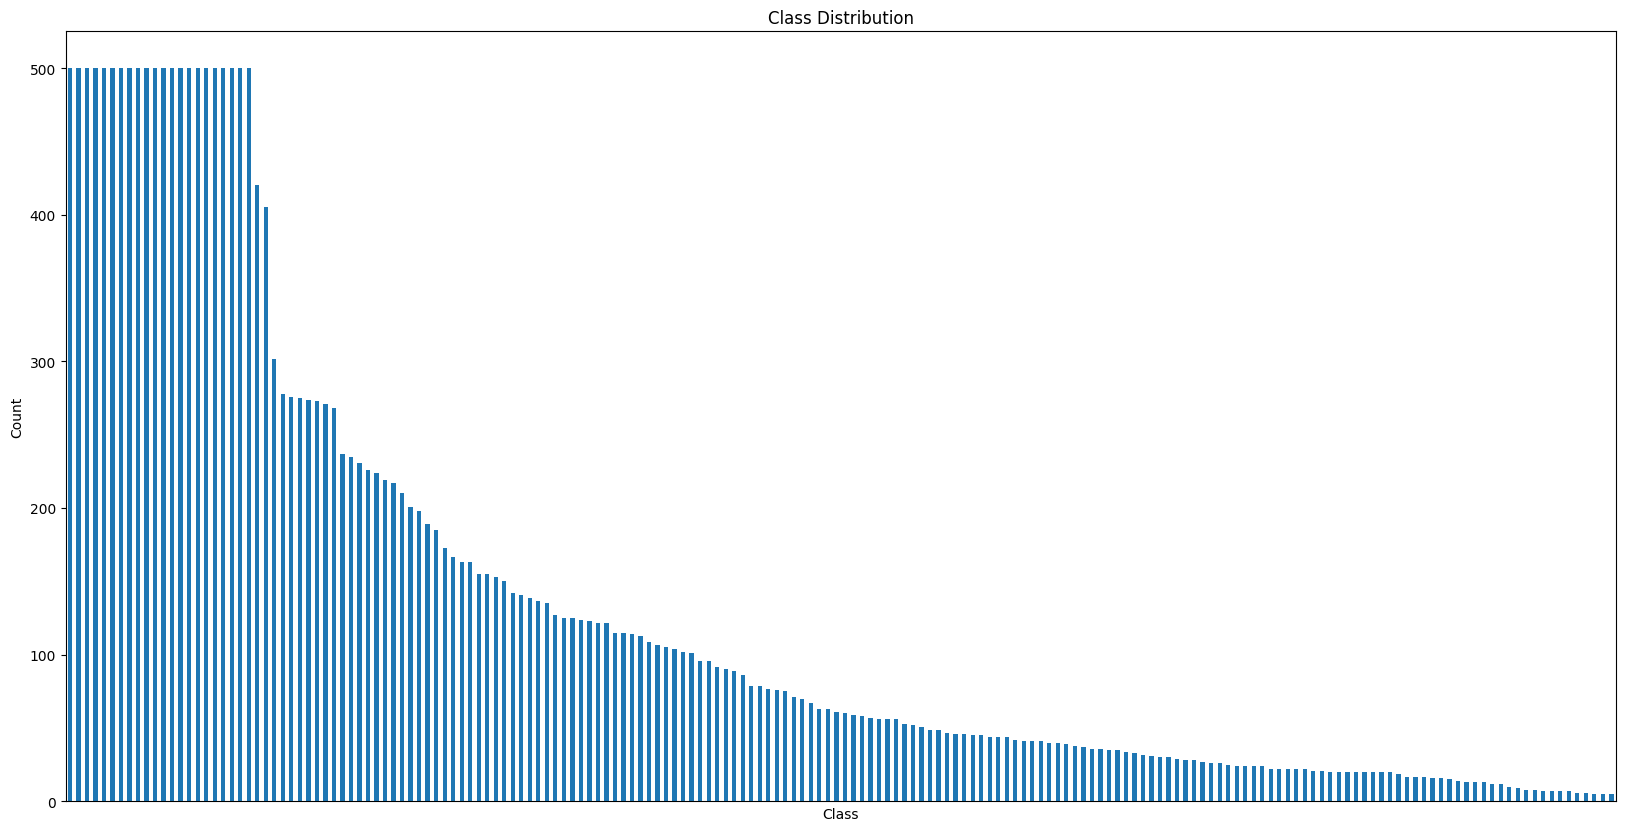

In [5]:
class_distibution = df['primary_label'].value_counts()

plt.figure(figsize=(20, 10))
class_distibution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([])
plt.show()

In [7]:
file_lengths = []
for i, filename in enumerate(df['filename']):
    audio, sr = lb.load(f"train_audio/{filename}")
    file_lengths.append(len(audio) / sr)


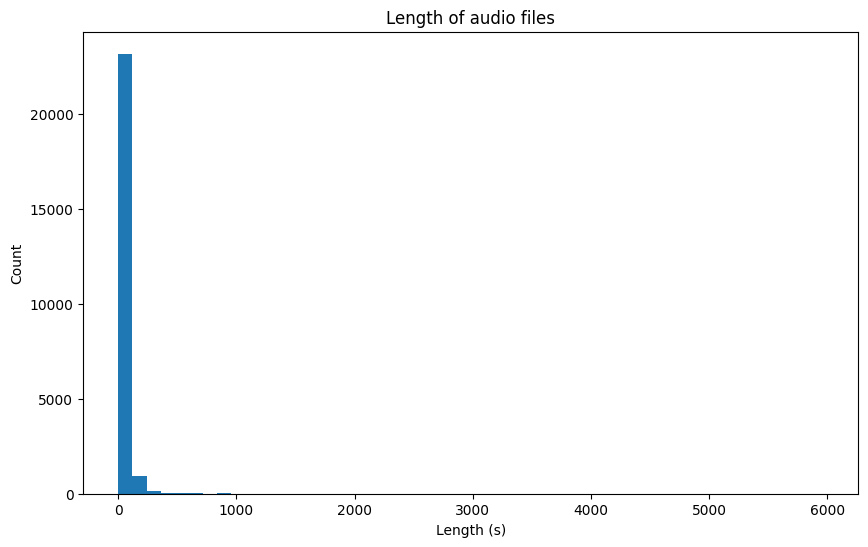

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(file_lengths, bins=50)
plt.title("Length of audio files")
plt.xlabel("Length (s)")
plt.ylabel("Count")
plt.show()

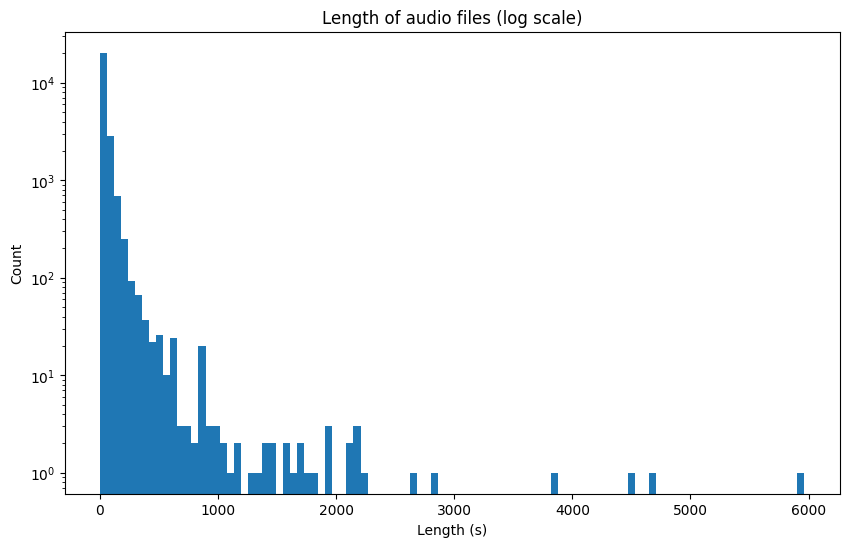

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(file_lengths, bins=100, log=True)
plt.title("Length of audio files (log scale)")
plt.xlabel("Length (s)")
plt.ylabel("Count")
plt.grid(False)
plt.show()

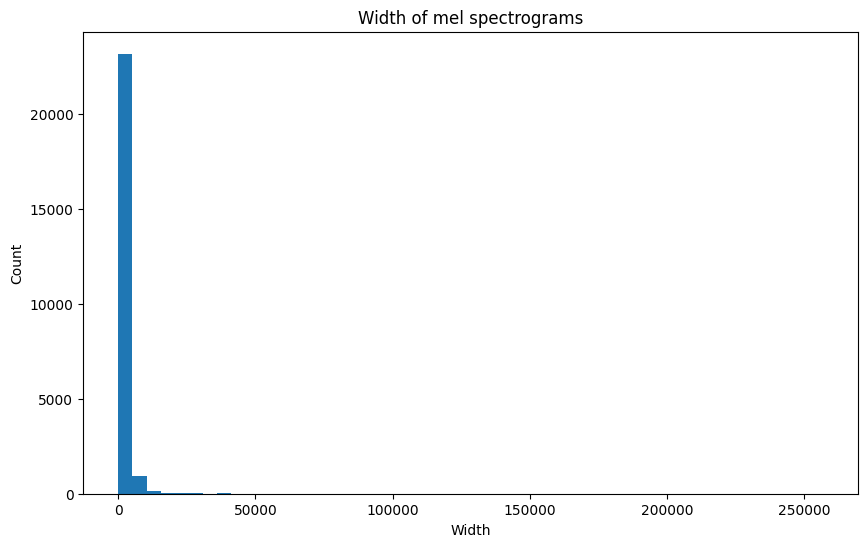

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(spectogram_widths, bins=50)
plt.title("Width of mel spectrograms")
plt.xlabel("Width")
plt.ylabel("Count")
plt.show()

In [9]:
print(f"Mean length: {np.mean(file_lengths)}s")
print(f"Median length: {np.median(file_lengths)}s")
print(f"Mode length: {statistics.mode(file_lengths)}s")
print(f"Max length: {np.max(file_lengths)}s")
print(f"Min length: {np.min(file_lengths)}s")
print(f"Number of unique lengths: {len(set(file_lengths))}s")

Mean length: 41.92445170542698s
Median length: 22.386031746031748s
Mode length: 8.04s
Max length: 5964.225034013605s
Min length: 0.47002267573696144s
Number of unique lengths: 10166s


In [12]:
percentiles = [10, 25, 50, 75, 90, 95, 99, 100]
values = np.percentile(file_lengths, percentiles)

for p, v in zip(percentiles, values):
    print(f"{p} percentile: {v:.2f} s")


10 percentile: 6.72 s
25 percentile: 11.21 s
50 percentile: 22.39 s
75 percentile: 44.67 s
90 percentile: 82.25 s
95 percentile: 122.47 s
99 percentile: 300.13 s
100 percentile: 5964.23 s


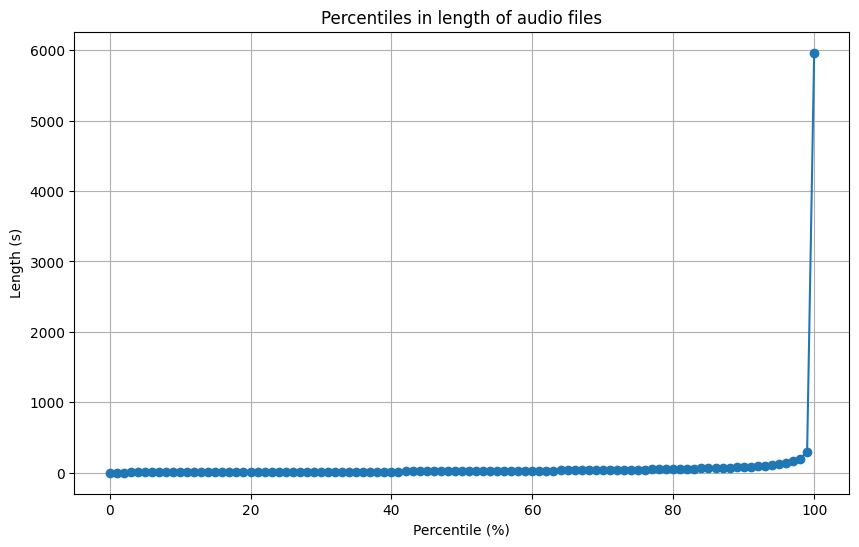

In [13]:
percentiles = np.arange(0, 101, 1)
values = np.percentile(file_lengths, percentiles)

plt.figure(figsize=(10, 6))
plt.plot(percentiles, values, marker="o")
plt.title("Percentiles in length of audio files")
plt.xlabel("Percentile (%)")
plt.ylabel("Length (s)")
plt.grid(True)
plt.show()

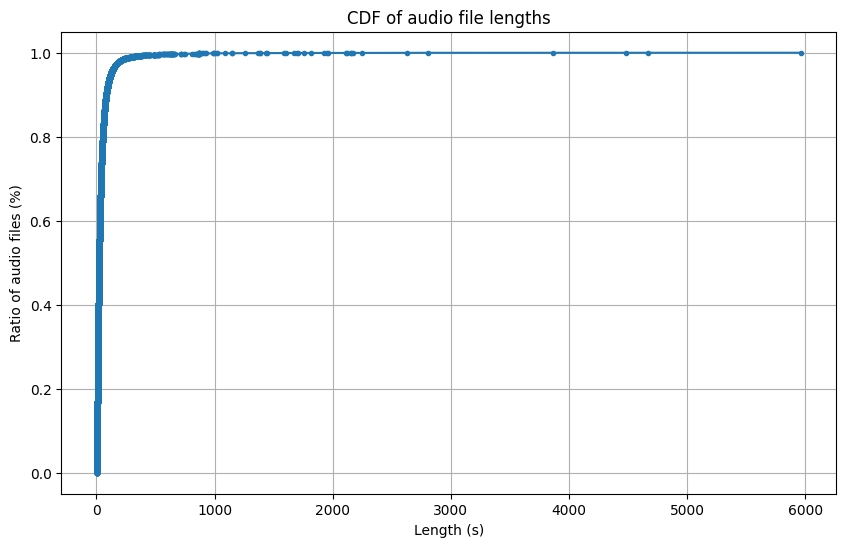

In [14]:
sorted_lengths = np.sort(file_lengths)

cdf = np.arange(1, len(sorted_lengths)+1) / len(sorted_lengths)

plt.figure(figsize=(10, 6))
plt.plot(sorted_lengths, cdf, marker=".", linestyle="-")
plt.title("CDF of audio file lengths")
plt.xlabel("Length (s)")
plt.ylabel("Ratio of audio files (%)")
plt.grid(True)
plt.show()

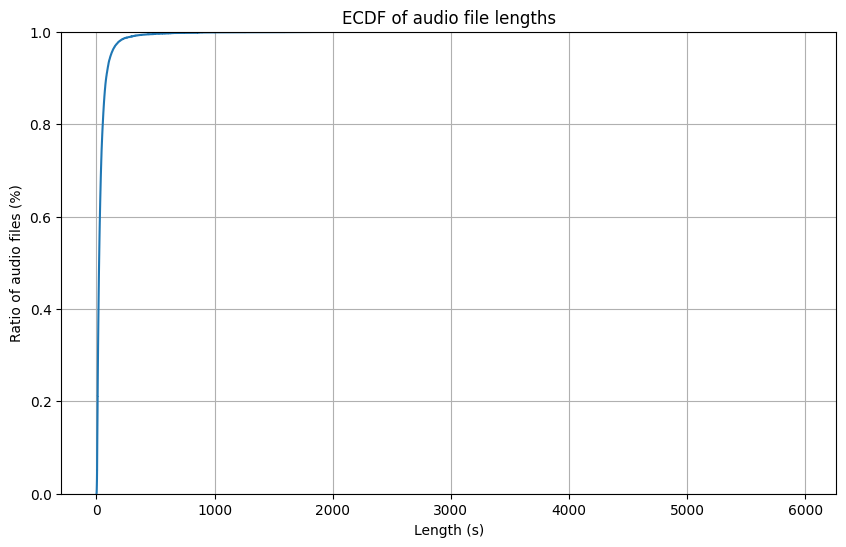

In [15]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(file_lengths)
plt.title("ECDF of audio file lengths")
plt.xlabel("Length (s)")
plt.ylabel("Ratio of audio files (%)")
plt.grid(True)
plt.show()


In [30]:
longest =  np.argmax(file_lengths)
print(f"Longest file: {longest}")
print(df[longest:longest+1])

Longest file: 3699
     primary_label secondary_labels  type  latitude  longitude  \
3699       blrwar1               []  ['']   58.6385    25.0257   

             scientific_name           common_name        author  \
3699  Acrocephalus dumetorum  Blyth's Reed Warbler  FlackoWeasel   

                                                license  rating  \
3699  Creative Commons Attribution-NonCommercial-Sha...     4.0   

                                url              filename  file_length  
3699  https://xeno-canto.org/826766  blrwar1/XC826766.ogg  5964.225034  


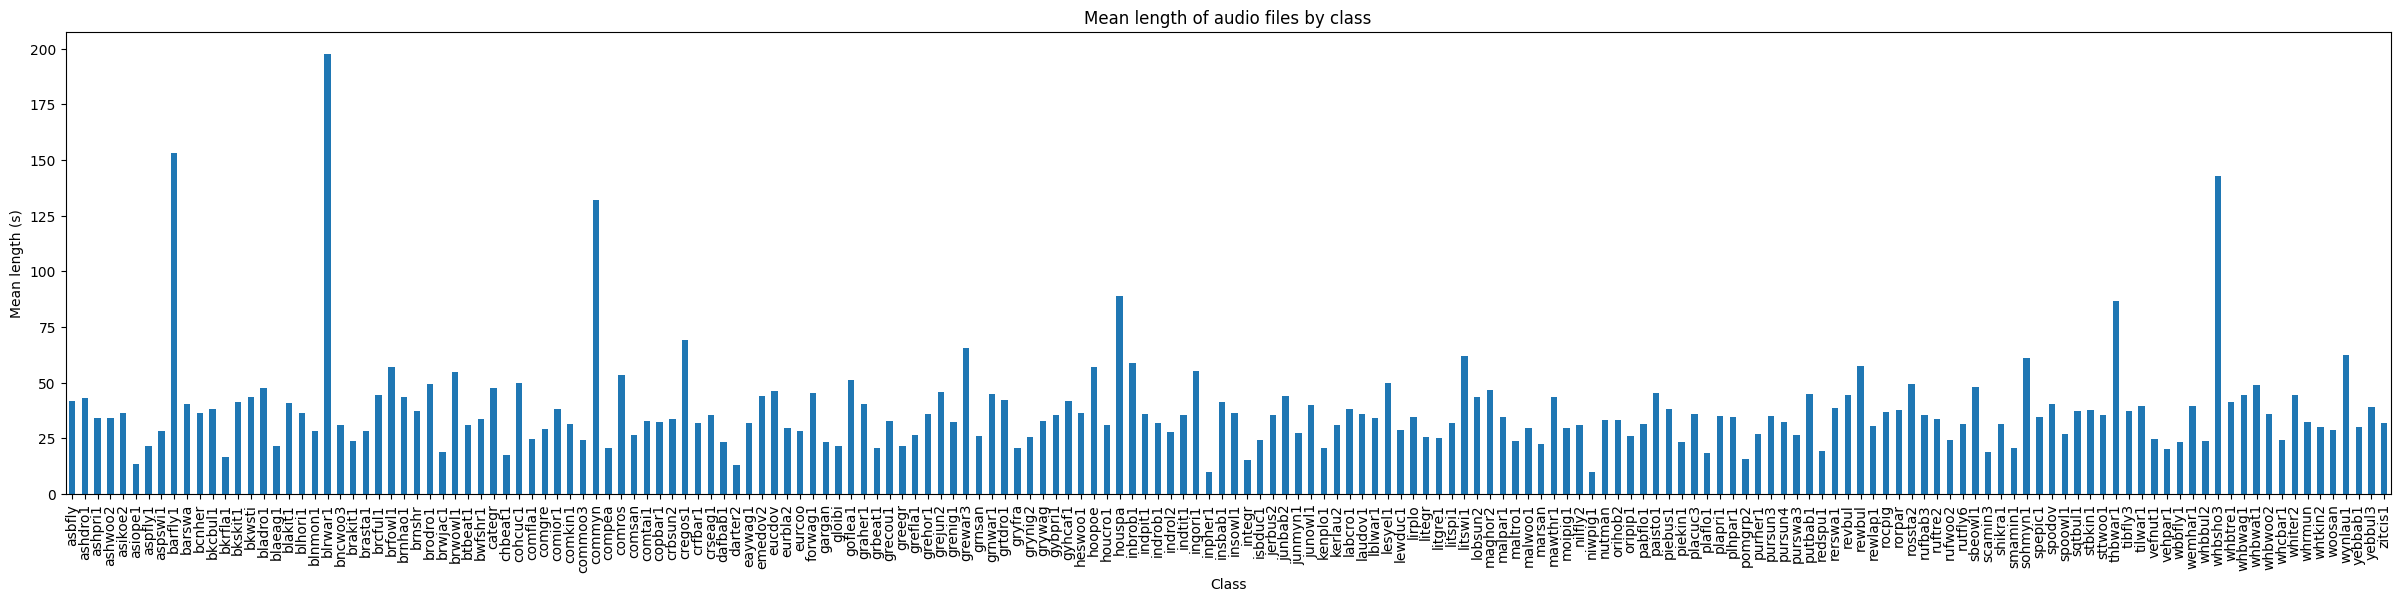

In [16]:
df['file_length'] = file_lengths
class_lengths = df.groupby('primary_label')['file_length'].mean()

plt.figure(figsize=(30, 6))
class_lengths.plot(kind='bar')
plt.title("Mean length of audio files by class")
plt.xlabel("Class")
plt.ylabel("Mean length (s)")
plt.show()


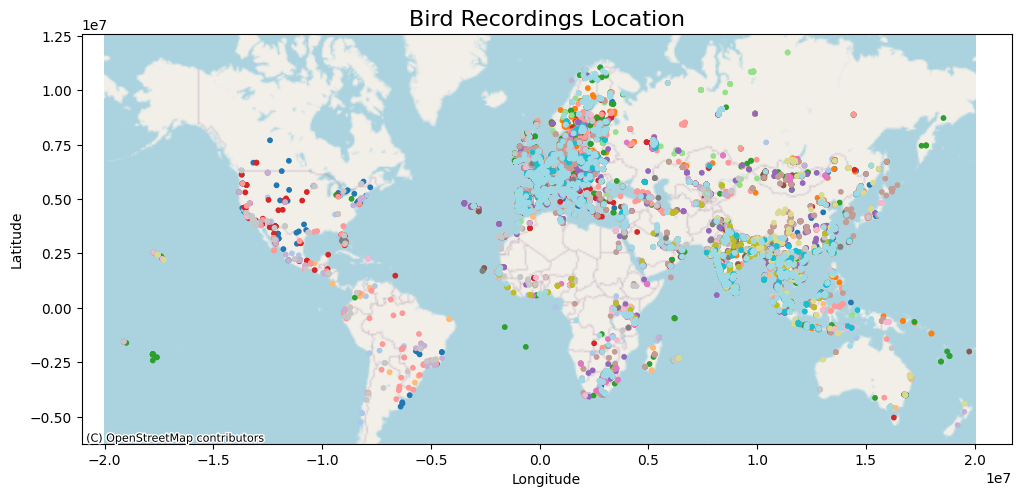

In [ ]:
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")  

gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, column='primary_label', legend=False, markersize=10, cmap='tab20')  
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Bird Recordings Location", fontsize=16)
plt.axes("off")
plt.show()